In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append("/Users/redstar/work/analysisHAL_miya/scripts/python_code-set/lib")
from common.io_data_bin          import input_bin_data_naxyzb, input_bin_data_nt
from common.statistics           import make_mean_err, make_JKsample
from fitting.fitfunc_type        import set_fitfunc_from_fname
from misc_QM.special_functions   import sph_harm_xyz, sph_harm_A1_xyz
from lattice.rotation_projection import rot_proj
from lattice.calc_laplacian      import lap, lap_4th_proc
from lattice.calc_potential      import calc_potential_t2, calc_potential_t2_num
from lattice.make_r_coordinates  import xyzdata_to_rdata, make_r_coord, make_rbin, divide_wave_L04, rbin_L04_separation
from lattice.misner_method       import Sph_harm_deco_misner
from sch_diffeq.solve_diffeq     import solve_sch_diff
from Tmatrix.convert_mat         import convert_TtoS
from Tmatrix.calc_phase_shift    import calc_phase_Sii, within_one
from sch_finiteV.solve_sch_finiteV import solve_sch_Fvol, solve_sch_Fvol_4th_prec
from multiprocessing             import Pool
# for fitting and phase shift calculation
from scipy.optimize import curve_fit
from sch_gauss_exp.solve_sch_GEM   import solve_sch_GEM

In [2]:
Lsize = 4
Tsize = 8

In [4]:
wave_org = np.array([np.fromfile("../consistency_check_i1ppsep_alt/4pt_correlator_%d"%it,'<c16') for it in range(Tsize)]).reshape(Tsize, Lsize, Lsize, Lsize)

In [5]:
wave_alt = np.fromfile("../consistency_check_i1ppsep_alt/NBS_sep_8tave",'<c16').reshape(Tsize, Lsize, Lsize, Lsize)

In [6]:
wave_org.imag

array([[[[ 0.00000000e+00,  2.38232356e+00,  0.00000000e+00,
          -2.38232356e+00],
         [-1.08879044e+00, -6.79564482e-01, -2.37772847e+00,
          -3.19965139e+00],
         [ 0.00000000e+00, -2.24393108e-01,  0.00000000e+00,
           2.24393108e-01],
         [ 1.08879044e+00,  3.19965139e+00,  2.37772847e+00,
           6.79564482e-01]],

        [[-1.15991003e+03, -1.15751607e+03, -1.16044211e+03,
          -1.16320730e+03],
         [-1.16057210e+03, -1.16135656e+03, -1.16275247e+03,
          -1.16278356e+03],
         [-1.16112854e+03, -1.16078716e+03, -1.16127145e+03,
          -1.16248145e+03],
         [-1.16007629e+03, -1.15706719e+03, -1.15876541e+03,
          -1.16229520e+03]],

        [[ 0.00000000e+00,  2.76440657e+00,  0.00000000e+00,
          -2.76440657e+00],
         [ 6.67137462e-01,  1.29158524e+00, -1.66429286e+00,
          -2.66683020e+00],
         [ 0.00000000e+00,  1.33374270e+00,  0.00000000e+00,
          -1.33374270e+00],
         [-6.6713

In [7]:
wave_alt.imag

array([[[[ 0.00000000e+00,  2.38232356e+00,  0.00000000e+00,
          -2.38232356e+00],
         [-1.08879044e+00, -6.79564482e-01, -2.37772847e+00,
          -3.19965139e+00],
         [ 0.00000000e+00, -2.24393108e-01,  0.00000000e+00,
           2.24393108e-01],
         [ 1.08879044e+00,  3.19965139e+00,  2.37772847e+00,
           6.79564482e-01]],

        [[-1.15991003e+03, -1.15751607e+03, -1.16044211e+03,
          -1.16320730e+03],
         [-1.16057210e+03, -1.16135656e+03, -1.16275247e+03,
          -1.16278356e+03],
         [-1.16112854e+03, -1.16078716e+03, -1.16127145e+03,
          -1.16248145e+03],
         [-1.16007629e+03, -1.15706719e+03, -1.15876541e+03,
          -1.16229520e+03]],

        [[ 0.00000000e+00,  2.76440657e+00,  0.00000000e+00,
          -2.76440657e+00],
         [ 6.67137462e-01,  1.29158524e+00, -1.66429286e+00,
          -2.66683020e+00],
         [ 0.00000000e+00,  1.33374270e+00,  0.00000000e+00,
          -1.33374270e+00],
         [-6.6713

In [8]:
wave_diff = (wave_org.real - wave_alt.real)

In [9]:
wave_diff

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 2.13162821e-14, -2.13162821e-14, -2.13162821e-14,
           0.00000000e+00],
         [ 0.00000000e+00,  7.10542736e-15,  0.00000000e+00,
          -7.10542736e-15],
         [-2.13162821e-14,  0.00000000e+00,  2.13162821e-14,
           2.13162821e-14]],

        [[-1.19904087e-14, -9.76996262e-15, -1.13242749e-14,
          -1.46549439e-14],
         [-2.04281037e-14, -1.66533454e-14, -1.73194792e-14,
          -2.35367281e-14],
         [-6.66133815e-15, -7.10542736e-15, -8.88178420e-15,
          -1.50990331e-14],
         [ 0.00000000e+00,  4.44089210e-16, -5.32907052e-15,
          -3.99680289e-15]],

        [[ 0.00000000e+00,  4.26325641e-14,  0.00000000e+00,
          -4.26325641e-14],
         [-1.42108547e-14,  3.55271368e-14, -1.42108547e-14,
           1.42108547e-14],
         [ 0.00000000e+00,  2.13162821e-14,  0.00000000e+00,
          -2.13162821e-14],
         [ 1.4210

In [10]:
wave_org_r = np.array([xyzdata_to_rdata(wave_org[it],False)[1] for it in range(Tsize)])

In [11]:
r = xyzdata_to_rdata(wave_org[0],False)[0].real

In [12]:
wave_alt_r = np.array([xyzdata_to_rdata(wave_alt[it],False)[1] for it in range(Tsize)])

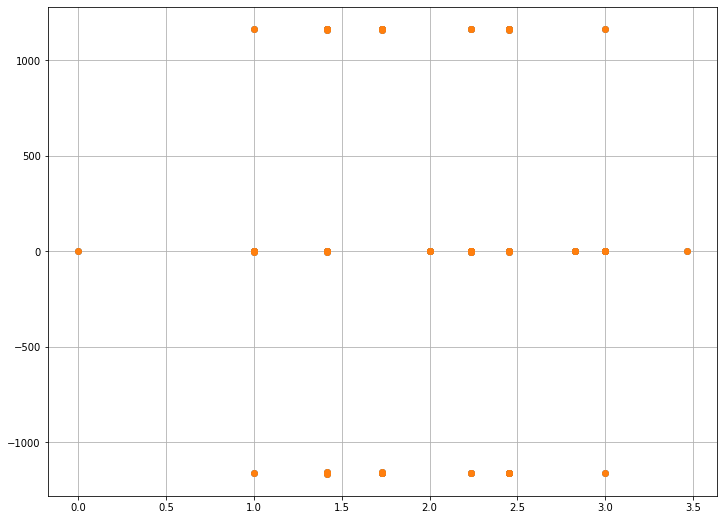

In [13]:
fig, axe = plt.subplots(figsize=(12,9))
it = 0
axe.plot(r, wave_org_r[it].imag, 'o')
axe.plot(r, wave_alt_r[it].imag, 'o')
axe.grid()

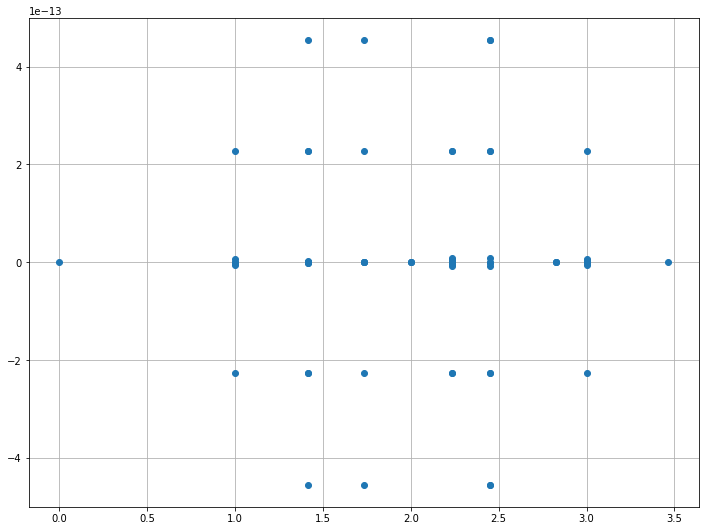

In [14]:
fig, axe = plt.subplots(figsize=(12,9))
it = 0
axe.plot(r, (wave_org_r[it].imag-wave_alt_r[it].imag), 'o')
#axe.plot(r, wave_alt_r[it], 'o')
axe.grid()